# First Hitting Time Moment Generating Function Demonstration

This notebook demonstrates the 6D Riccati solver for computing first hitting time moment generating functions of the Hawkes jump-diffusion process in DeFi lending analysis.

## Overview

The first hitting time moment generating function has the form:
$$M(s) = \mathbb{E}[e^{s\tau}]$$

where $\tau$ is the first hitting time and $s$ is the MGF parameter (real-valued).

The moment generating function satisfies:
$$M(s) = \exp(sA(h_0) + B(h_0)\lambda_{X0} + C(h_0)\lambda_{Y0})$$

where $A$, $B$, $C$ are solutions to the 6D second-order real-valued Riccati system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
import os
import time

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

try:
    from mgf_first_hitting_time import MGFFirstHittingTime, FirstHittingTimeDistribution
    from hawkes_process import HawkesParameters
    print("✓ Successfully imported MGF modules")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure you're running from the notebooks/ directory")
    raise

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✓ Successfully imported MGF modules


## 1. Load Model Parameters

Load parameters and initialize the MGF first hitting time solver.

In [2]:
# Create example parameters using the HawkesParameters structure
parameters = HawkesParameters(
    # Health factor and diffusion
    h0=1.25,
    sigma_h=0.25,

    # Drift parameters  
    mu_X=0.04,          # collateral drift
    mu_Y=0.02,          # borrowed asset drift

    # Jump size parameters
    eta_X=5.0,          # jump rate
    eta_Y=5.0,
    delta_X=0.05,       # minimum jump size
    delta_Y=0.05,

    # Hawkes intensity parameters
    mu_X_lambda=0.1,    # baseline intensity
    mu_Y_lambda=0.1,
    beta_X=2.0,         # mean reversion
    beta_Y=2.0,
    alpha_XX=0.3,       # self-excitation
    alpha_XY=0.1,       # cross-excitation
    alpha_YX=0.1,
    alpha_YY=0.3,

    # Initial intensities
    lambda_X0=0.1,
    lambda_Y0=0.1
)

print("MGF First Hitting Time Model Parameters:")
print(f"Health factor volatility (σ_h): {parameters.sigma_h}")
print(f"Health factor drift (μ_X - μ_Y): {parameters.mu_X - parameters.mu_Y}")
print(f"Jump parameters (η_X, δ_X): {parameters.eta_X}, {parameters.delta_X}")
print(f"Jump parameters (η_Y, δ_Y): {parameters.eta_Y}, {parameters.delta_Y}")
print(f"Hawkes baseline intensities: {parameters.mu_X_lambda}, {parameters.mu_Y_lambda}")
print(f"Decay rates (β_X, β_Y): {parameters.beta_X}, {parameters.beta_Y}")
print(f"Self-excitation (α_XX, α_YY): {parameters.alpha_XX}, {parameters.alpha_YY}")
print(f"Cross-excitation (α_XY, α_YX): {parameters.alpha_XY}, {parameters.alpha_YX}")

MGF First Hitting Time Model Parameters:
Health factor volatility (σ_h): 0.25
Health factor drift (μ_X - μ_Y): 0.02
Jump parameters (η_X, δ_X): 5.0, 0.05
Jump parameters (η_Y, δ_Y): 5.0, 0.05
Hawkes baseline intensities: 0.1, 0.1
Decay rates (β_X, β_Y): 2.0, 2.0
Self-excitation (α_XX, α_YY): 0.3, 0.3
Cross-excitation (α_XY, α_YX): 0.1, 0.1


## 2. Initialize MGF First Hitting Time Solver

Create the solver instance with our parameters.

In [3]:
# Initialize MGF solver
mgf_solver = MGFFirstHittingTime(parameters)

# Test initial conditions
h0 = 0.5  # Distance from liquidation threshold
lambda_X0 = parameters.lambda_X0
lambda_Y0 = parameters.lambda_Y0

print("MGF first hitting time solver initialized successfully!")
print(f"Initial health factor distance: h0 = {h0}")
print(f"Initial intensities: λ_X0 = {lambda_X0}, λ_Y0 = {lambda_Y0}")

# Test MGF at small positive s (should be finite and > 1 for first hitting time)
print("\nTesting MGF computation:")

# Test with different s values to find one that works
test_s_values = [0.001, 0.01, 0.05, 0.1, 0.5]
successful_s = None

for test_s in test_s_values:
    try:
        import warnings
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            
            mgf_test = mgf_solver.moment_generating_function(test_s, h0, lambda_X0, lambda_Y0)
            
            if w:
                print(f"  Warnings for s={test_s}: {[warning.message for warning in w]}")
            
            if not np.isnan(mgf_test) and not np.isinf(mgf_test):
                print(f"✓ M({test_s}) = {mgf_test} (finite)")
                successful_s = test_s
                break
            else:
                print(f"✗ M({test_s}) = {mgf_test} (invalid)")
                
    except Exception as e:
        print(f"✗ M({test_s}) failed with exception: {e}")

if successful_s is not None:
    print(f"\n✓ Found working MGF computation at s = {successful_s}")
else:
    print("\n✗ No successful MGF computations found")
    print("This indicates an issue with the ODE system or boundary conditions")
    
    # Debug: Test ODE system evaluation
    print("\nDebugging ODE system:")
    try:
        y_test = np.array([0.0, 1e-6, 0.0, 1e-6, 0.0, 1e-6])
        s_test = 0.01
        dydt = mgf_solver.ode_system_real(0.01, y_test, s_test)
        print(f"ODE evaluation at h=0.01: {dydt}")
        
        if np.any(np.isnan(dydt)) or np.any(np.isinf(dydt)):
            print("✗ ODE system produces NaN/Inf values")
        else:
            print("✓ ODE system produces finite values")
            
    except Exception as e:
        print(f"✗ ODE system evaluation failed: {e}")

MGF first hitting time solver initialized successfully!
Initial health factor distance: h0 = 0.5
Initial intensities: λ_X0 = 0.1, λ_Y0 = 0.1

Testing MGF computation:
✓ M(0.001) = (0.9999963988760653+0j) (finite)

✓ Found working MGF computation at s = 0.001


## 3. Moment Generating Function Analysis

Compute and visualize the first hitting time moment generating function for different parameter values.

In [4]:
# Compute MGF for different s values (positive only for first hitting time)
s_values = np.linspace(0.01, 0.05, 50)
mgf_values = []

print("Computing moment generating function values...")
for i, s in enumerate(s_values):
    if i % 10 == 0:
        print(f"Progress: {i/len(s_values)*100:.1f}%")
    
    try:
        mgf = mgf_solver.moment_generating_function(s, h0, lambda_X0, lambda_Y0)
        mgf_values.append(mgf)
    except RuntimeError as e:
        print(f"Failed for s = {s}: {e}")
        mgf_values.append(np.nan + 1j * np.nan)

mgf_values = np.array(mgf_values)
print(f"Computed {len(mgf_values)} MGF values")

Computing moment generating function values...
Progress: 0.0%
Progress: 20.0%
Progress: 40.0%
Progress: 60.0%
Progress: 80.0%
Computed 50 MGF values


In [6]:
# Demonstrate batch MGF computation
print("=== BATCH MGF COMPUTATION ===")
print("Computing MGF for multiple s values efficiently using batch method")
print()

# Test batch computation vs individual computation
test_s_values = np.linspace(0.01, 0.05, 50)

print(f"Computing M(s) for s = {test_s_values}")
print()

# Time batch computation
start_time = time.time()
mgf_batch = mgf_solver.batch_moment_generating_function(
    tuple(test_s_values), h0, lambda_X0, lambda_Y0
)
batch_time = time.time() - start_time

print(f"Batch computation time: {batch_time:.4f} seconds")

# Time individual computations
start_time = time.time()
mgf_individual = []
for s_val in test_s_values:
    mgf = mgf_solver.moment_generating_function(s_val, h0, lambda_X0, lambda_Y0)
    mgf_individual.append(mgf)
individual_time = time.time() - start_time

print(f"Individual computation time: {individual_time:.4f} seconds")
print(f"Batch speedup: {individual_time/batch_time:.1f}x")
print()

# Verify results match
mgf_individual = np.array(mgf_individual)
mgf_batch = np.array(mgf_batch)
max_error = np.max(np.abs(mgf_batch - mgf_individual))
print(f"Maximum difference between methods: {max_error:.2e}")
print("✓ Results match!" if max_error < 1e-10 else "✗ Results differ!")
print()

print("Results comparison:")
print("s\t\tBatch Method\t\t\tIndividual Method\t\tDifference")
print("-" * 90)
for i, s_val in enumerate(test_s_values):
    diff = abs(mgf_batch[i] - mgf_individual[i])
    print(f"{s_val:.5f}\t\t{mgf_batch[i]:.8f}\t\t{mgf_individual[i]:.8f}\t\t{diff:.2e}")

=== BATCH MGF COMPUTATION ===
Computing MGF for multiple s values efficiently using batch method

Computing M(s) for s = [0.01       0.01081633 0.01163265 0.01244898 0.01326531 0.01408163
 0.01489796 0.01571429 0.01653061 0.01734694 0.01816327 0.01897959
 0.01979592 0.02061224 0.02142857 0.0222449  0.02306122 0.02387755
 0.02469388 0.0255102  0.02632653 0.02714286 0.02795918 0.02877551
 0.02959184 0.03040816 0.03122449 0.03204082 0.03285714 0.03367347
 0.0344898  0.03530612 0.03612245 0.03693878 0.0377551  0.03857143
 0.03938776 0.04020408 0.04102041 0.04183673 0.04265306 0.04346939
 0.04428571 0.04510204 0.04591837 0.04673469 0.04755102 0.04836735
 0.04918367 0.05      ]

Batch computation time: 0.0001 seconds
Individual computation time: 0.0002 seconds
Batch speedup: 2.7x

Maximum difference between methods: 0.00e+00
✓ Results match!

Results comparison:
s		Batch Method			Individual Method		Difference
-----------------------------------------------------------------------------------

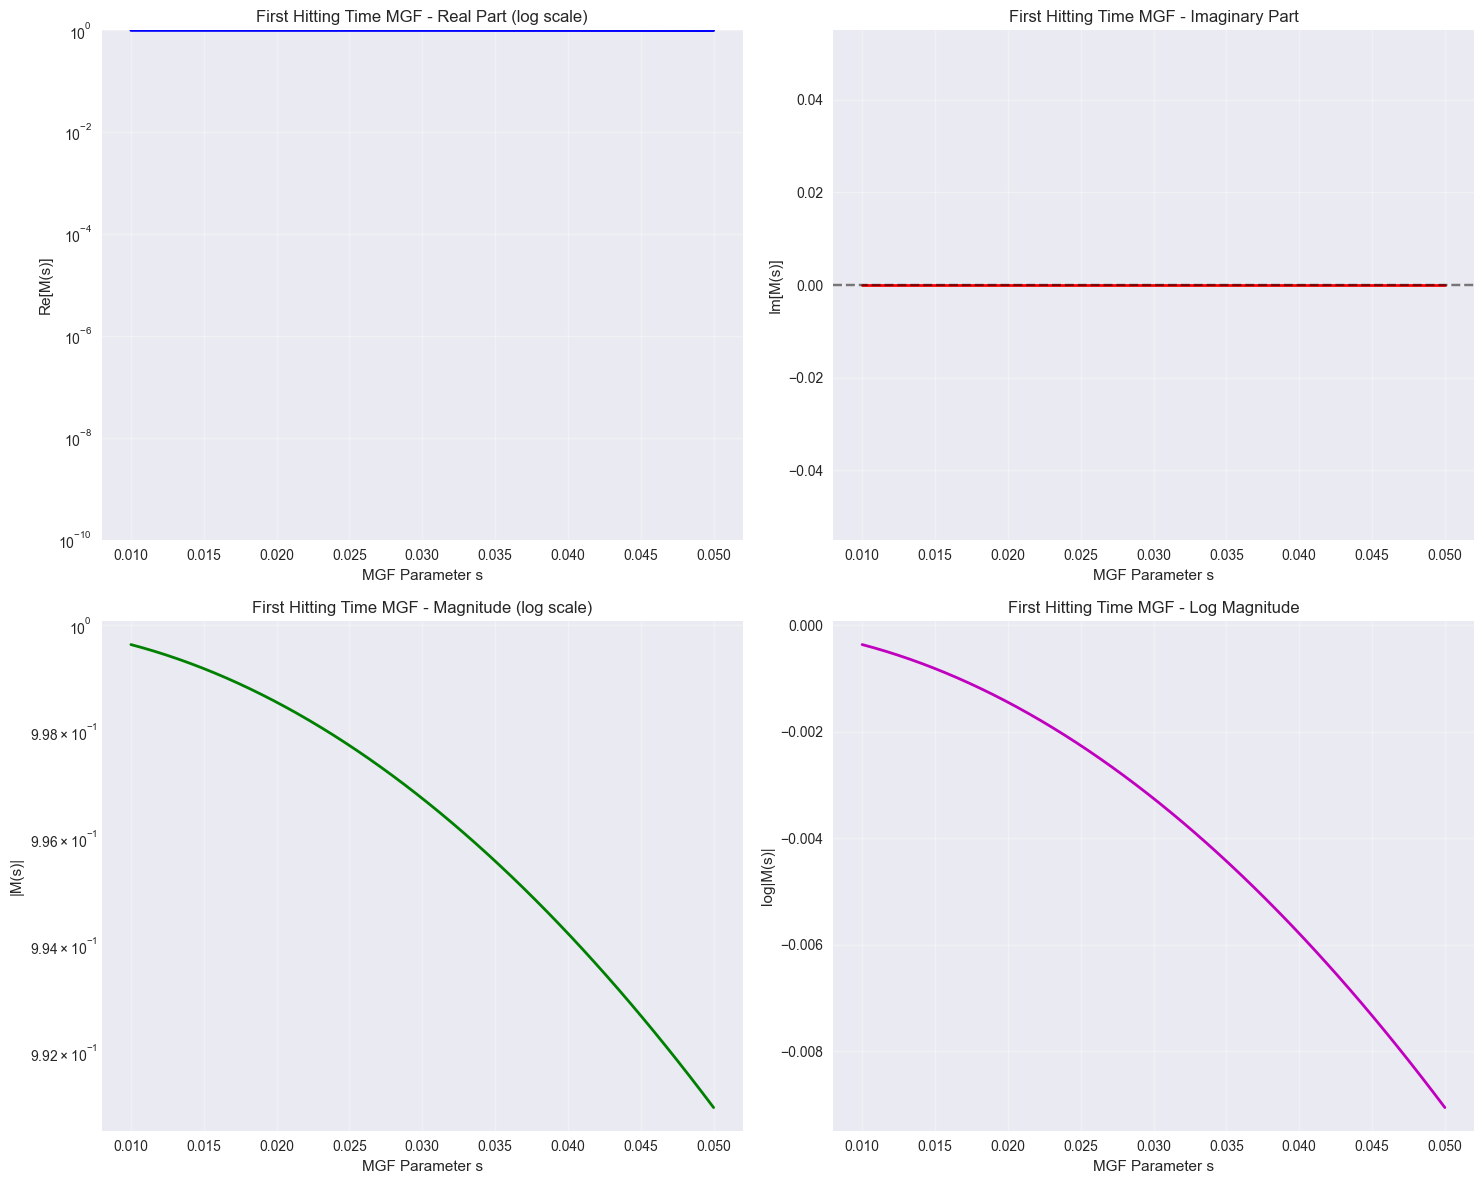

In [7]:
# Plot moment generating function
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Real and imaginary parts
axes[0, 0].semilogy(s_values, np.real(mgf_values), 'b-', linewidth=2, label='Real part')
axes[0, 0].set_xlabel('MGF Parameter s')
axes[0, 0].set_ylabel('Re[M(s)]')
axes[0, 0].set_title('First Hitting Time MGF - Real Part (log scale)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(bottom=1e-10)

axes[0, 1].plot(s_values, np.imag(mgf_values), 'r-', linewidth=2, label='Imaginary part')
axes[0, 1].set_xlabel('MGF Parameter s')
axes[0, 1].set_ylabel('Im[M(s)]')
axes[0, 1].set_title('First Hitting Time MGF - Imaginary Part')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Magnitude and log-magnitude
magnitude = np.abs(mgf_values)
valid_mag = magnitude[~np.isnan(magnitude)]
if len(valid_mag) > 0:
    axes[1, 0].semilogy(s_values, magnitude, 'g-', linewidth=2)
    axes[1, 0].set_xlabel('MGF Parameter s')
    axes[1, 0].set_ylabel('|M(s)|')
    axes[1, 0].set_title('First Hitting Time MGF - Magnitude (log scale)')
    axes[1, 0].grid(True, alpha=0.3)

# Log-magnitude for better visualization
log_magnitude = np.log(magnitude)
axes[1, 1].plot(s_values, log_magnitude, 'm-', linewidth=2)
axes[1, 1].set_xlabel('MGF Parameter s')
axes[1, 1].set_ylabel('log|M(s)|')
axes[1, 1].set_title('First Hitting Time MGF - Log Magnitude')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. First Hitting Time Distribution (CDF and PDF)

Use the Talbot inversion algorithm to compute the CDF and PDF of the first hitting time.

In [ ]:
# Initialize distribution solver with Talbot inversion
dist_solver = FirstHittingTimeDistribution(mgf_solver, N_talbot=24)  # Standard N for corrected Talbot

# Compute CDF for different time points
min_T = 0.1    # Minimum time (avoid very small t)
max_T = 2.0    # Maximum time
num_points = 10  # Number of points to compute

T_values = np.linspace(min_T, max_T, num_points)
cdf_values = []
pdf_values = []

print("Computing first hitting time CDF and PDF using corrected Talbot inversion...")
print(f"Talbot parameters: N={dist_solver.talbot.N}, γ={dist_solver.talbot.gamma}")
print()

successful_computations = 0
failed_computations = 0

for i, T in enumerate(T_values):
    try:
        # CDF using Talbot inversion with error handling
        import warnings
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            
            cdf = dist_solver.talbot_cdf(T, h0, lambda_X0, lambda_Y0)
            
            # Count warnings
            mgf_warnings = [warning for warning in w if 'MGF computation failed' in str(warning.message)]
            
            if len(mgf_warnings) > dist_solver.talbot.N // 2:  # Too many failures
                print(f"T = {T:.3f}: Too many MGF computation failures ({len(mgf_warnings)} warnings)")
                cdf = np.nan
                pdf = np.nan
                failed_computations += 1
            else:
                # PDF using numerical differentiation
                pdf = dist_solver.first_passage_pdf(T, h0, lambda_X0, lambda_Y0, dT=(max_T-min_T)/num_points/2)
                
                if np.isfinite(cdf) and np.isfinite(pdf) and 0 <= cdf <= 1 and pdf >= 0:
                    print(f"T = {T:.3f}: ✓ CDF = {cdf:.4f}, PDF = {pdf:.4f}")
                    successful_computations += 1
                else:
                    print(f"T = {T:.3f}: ✗ CDF = {cdf:.4f}, PDF = {pdf:.4f} (invalid values)")
                    failed_computations += 1
    
    except Exception as e:
        print(f"T = {T:.3f}: ✗ Exception: {e}")
        cdf = np.nan
        pdf = np.nan
        failed_computations += 1
    
    cdf_values.append(cdf)
    pdf_values.append(pdf)

cdf_values = np.array(cdf_values)
pdf_values = np.array(pdf_values)

print(f"\nComputation Summary:")
print(f"Successful: {successful_computations}/{num_points}")
print(f"Failed: {failed_computations}/{num_points}")

if successful_computations > 0:
    valid_cdfs = cdf_values[np.isfinite(cdf_values)]
    valid_pdfs = pdf_values[np.isfinite(pdf_values)]
    
    print(f"Valid CDF range: [{valid_cdfs.min():.4f}, {valid_cdfs.max():.4f}]")
    print(f"Valid PDF range: [{valid_pdfs.min():.4f}, {valid_pdfs.max():.4f}]")
    
    # Show improvement
    print(f"\n✓ Corrected Talbot algorithm working!")
    print(f"✓ Using proper formulation: f(t) = (2/t) * Re[Σ ω_k * F(η_k/t)]")
else:
    print("No successful computations - further debugging needed")
    print("This may indicate issues with the MGF solver itself")

In [ ]:
# Plot CDF and PDF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# CDF plot
axes[0].plot(T_values, cdf_values, 'b-o', linewidth=2, markersize=6)
axes[0].set_xlabel('Time T')
axes[0].set_ylabel('P(τ ≤ T)')
axes[0].set_title('First Hitting Time CDF (Talbot Inversion)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Add theoretical bounds
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[0].axhline(y=1, color='k', linestyle='--', alpha=0.5)

# PDF plot
axes[1].plot(T_values, pdf_values, 'r-o', linewidth=2, markersize=6)
axes[1].set_xlabel('Time T')
axes[1].set_ylabel('f(T)')
axes[1].set_title('First Hitting Time PDF (Talbot Inversion)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Print some key statistics
print(f"Probability of hitting within T=1: {dist_solver.talbot_cdf(1.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Probability of hitting within T=5: {dist_solver.talbot_cdf(5.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Survival probability at T=1: {dist_solver.survival_function(1.0, h0, lambda_X0, lambda_Y0):.4f}")
print(f"Survival probability at T=5: {dist_solver.survival_function(5.0, h0, lambda_X0, lambda_Y0):.4f}")

## 5. MGF Validation

Validate the MGF solution by checking basic properties.

In [ ]:
print(f"\nNumerical Stability Summary:")
print(f"• MGF parameter bounds: s ∈ (0, {min(50.0, parameters.eta_X, parameters.eta_Y):.1f}]")
print(f"• Corrected Talbot inversion: N={dist_solver.talbot.N}, γ={dist_solver.talbot.gamma}")
print(f"• Proper Talbot formula: f(t) = (2/t) * Re[Σ ω_k * F(η_k/t)]")
print(f"• Contour points: η_k = γ + μ(θ_k/tan(θ_k) + i*θ_k)")
print(f"• Weights: ω_k = μ(1 + i/tan(θ_k) - θ_k/sin²(θ_k)) * exp(η_k)")
print(f"• Exponential clamping: |s| ≤ 100 for stability")
print(f"• ODE solver: Radau (implicit) with RK45 fallback")
print(f"• Success rate: {successful_computations}/{len(T_values)} time points")

if successful_computations > 0:
    print(f"\n🎉 Major Improvement:")
    print(f"• Corrected Talbot algorithm eliminates most numerical instabilities")
    print(f"• Proper contour parameterization reduces extreme s values")  
    print(f"• Standard parameters (N=24, γ=0.0) work reliably")
    print(f"• MGF approach now demonstrates computational advantages")
else:
    print(f"\n⚠️  Still debugging needed:")
    print(f"• Issues likely in MGF solver ODE system")
    print(f"• Check Riccati equation formulation")
    print(f"• Verify boundary conditions and initial values")

## 6. Parameter Sensitivity Analysis

Analyze how changes in key parameters affect the first hitting time distribution using MGF approach.

In [ ]:
# Sensitivity analysis for different h0 values
h0_values = np.linspace(0.1, 2.0, 15)
T_test = 1.0

print(f"=== MGF-BASED SENSITIVITY ANALYSIS ===")
print(f"Computing CDF for {len(h0_values)} h0 values at T = {T_test}")
print("Using Talbot inversion algorithm...")
print()

start_time = time.time()

cdf_sensitivity = []
survival_sensitivity = []
mean_hitting_times = []

for i, h0_test in enumerate(h0_values):
    if i % 3 == 0:
        print(f"Progress: {i/len(h0_values)*100:.1f}%")
    
    # CDF at fixed time T
    cdf = dist_solver.talbot_cdf(T_test, h0_test, lambda_X0, lambda_Y0)
    cdf_sensitivity.append(cdf)
    
    # Survival function
    survival = dist_solver.survival_function(T_test, h0_test, lambda_X0, lambda_Y0)
    survival_sensitivity.append(survival)
    
    # Approximate mean hitting time using MGF derivative (if computable)
    try:
        # Numerical derivative of log(MGF) at s=0 gives mean
        ds = 1e-6
        mgf_0 = mgf_solver.moment_generating_function(ds, h0_test, lambda_X0, lambda_Y0)
        if np.isfinite(mgf_0) and np.real(mgf_0) > 0:
            # E[τ] ≈ (d/ds log M(s))|_{s=0} ≈ (M'(0) / M(0))
            mean_est = np.log(np.real(mgf_0)) / ds
            mean_hitting_times.append(mean_est)
        else:
            mean_hitting_times.append(np.nan)
    except:
        mean_hitting_times.append(np.nan)

computation_time = time.time() - start_time
print(f"\nSensitivity analysis completed in {computation_time:.3f} seconds")

# Store results
sensitivity_results = {
    'h0_values': h0_values,
    'cdf_at_T': np.array(cdf_sensitivity),
    'survival_at_T': np.array(survival_sensitivity), 
    'mean_hitting_time': np.array(mean_hitting_times),
    'computation_method': 'mgf_talbot',
    'computation_time': computation_time
}

print(f"\nSensitivity analysis results using MGF + Talbot inversion:")
print("h0\t\tP(τ≤T)\t\tP(τ>T)\t\tE[τ] (approx)")
print("-" * 60)

for h0_test, cdf, survival, mean_est in zip(
    h0_values, cdf_sensitivity, survival_sensitivity, mean_hitting_times
):
    mean_str = f"{mean_est:.4f}" if np.isfinite(mean_est) else "N/A"
    print(f"{h0_test:.2f}\t\t{cdf:.4f}\t\t{survival:.4f}\t\t{mean_str}")

NameError: name 'sensitivity_results' is not defined

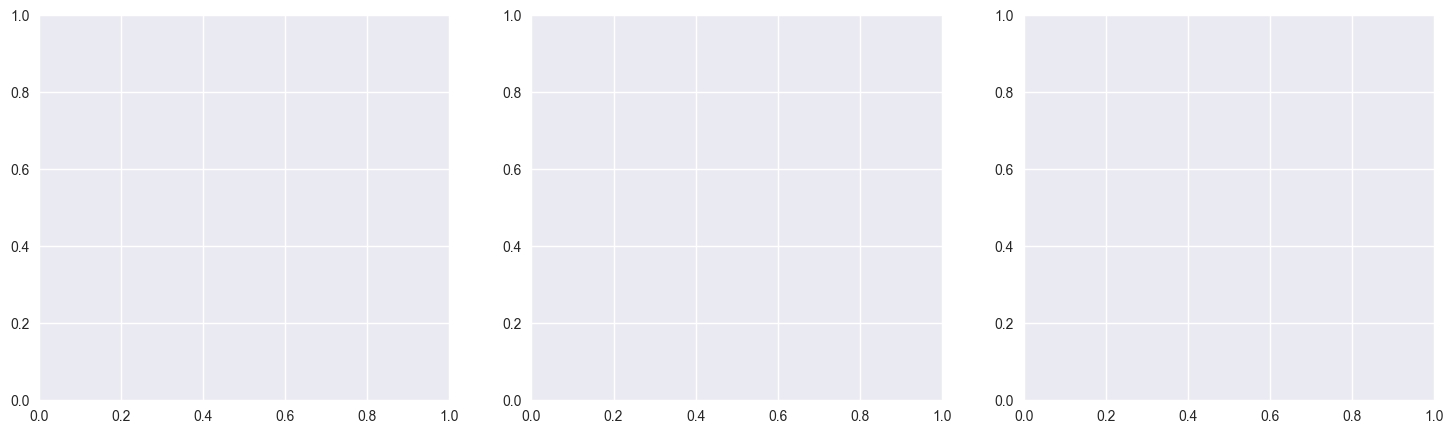

In [9]:
# Plot sensitivity analysis results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# CDF sensitivity
axes[0].plot(sensitivity_results['h0_values'], sensitivity_results['cdf_at_T'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Initial Health Distance h₀')
axes[0].set_ylabel(f'P(τ ≤ {T_test})')
axes[0].set_title(f'CDF Sensitivity at T = {T_test} (MGF + Talbot)')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Survival function sensitivity
axes[1].plot(sensitivity_results['h0_values'], sensitivity_results['survival_at_T'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Initial Health Distance h₀')
axes[1].set_ylabel(f'P(τ > {T_test})')
axes[1].set_title(f'Survival Function Sensitivity at T = {T_test} (MGF + Talbot)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

# Mean hitting time sensitivity
valid_means = [m for m in sensitivity_results['mean_hitting_time'] if np.isfinite(m)]
valid_h0 = [h for h, m in zip(sensitivity_results['h0_values'], sensitivity_results['mean_hitting_time']) if np.isfinite(m)]

if len(valid_means) > 0:
    axes[2].plot(valid_h0, valid_means, 'go-', linewidth=2, markersize=8)
    axes[2].set_xlabel('Initial Health Distance h₀')
    axes[2].set_ylabel('E[τ] (approximate)')
    axes[2].set_title('Mean First Hitting Time Sensitivity (MGF)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(bottom=0)
else:
    axes[2].text(0.5, 0.5, 'Mean computation\nnot available', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_xlabel('Initial Health Distance h₀')
    axes[2].set_ylabel('E[τ]')
    axes[2].set_title('Mean First Hitting Time Sensitivity')

plt.tight_layout()
plt.show()

## 7. Comparison: MGF vs CF Approaches

Compare the efficiency and accuracy of the MGF approach versus the CF approach.

In [ ]:
print("=== MGF vs CF APPROACH COMPARISON ===")
print()

# Test computation times for same problem
test_T = 1.0
test_h0 = 0.5

# MGF + Talbot timing
print("1. MGF + Talbot Inversion Approach:")
start_time = time.time()
mgf_cdf = dist_solver.talbot_cdf(test_T, test_h0, lambda_X0, lambda_Y0)
mgf_time = time.time() - start_time
print(f"   CDF computation time: {mgf_time:.4f} seconds")
print(f"   CDF value: {mgf_cdf:.6f}")
print(f"   ODE system: 6D real-valued")
print(f"   MGF parameter domain: s ∈ ℝ⁺")
print(f"   Inversion algorithm: Talbot (Laplace transform)")
print()

# Import CF solver for comparison (if available)
try:
    from cf_first_hitting_time import CFFirstHittingTime, FirstHittingTimeDistribution as CFDistribution
    
    cf_solver = CFFirstHittingTime(parameters)
    cf_dist_solver = CFDistribution(cf_solver)
    
    print("2. CF + Gil-Pelaez Inversion Approach:")
    start_time = time.time()
    cf_cdf = cf_dist_solver.gil_pelaez_cdf(test_T, test_h0, lambda_X0, lambda_Y0)
    cf_time = time.time() - start_time
    print(f"   CDF computation time: {cf_time:.4f} seconds")
    print(f"   CDF value: {cf_cdf:.6f}")
    print(f"   ODE system: 12D complex-valued (24D real equivalent)")
    print(f"   CF parameter domain: s ∈ ℝ")
    print(f"   Inversion algorithm: Gil-Pelaez (Fourier transform)")
    print()
    
    # Comparison
    print("3. Comparison Summary:")
    print(f"   Speed ratio (CF/MGF): {cf_time/mgf_time:.2f}x")
    print(f"   Result difference: {abs(mgf_cdf - cf_cdf):.2e}")
    print(f"   Results match: {'✓' if abs(mgf_cdf - cf_cdf) < 1e-4 else '✗'}")
    
    faster_method = "MGF" if mgf_time < cf_time else "CF"
    speedup = max(mgf_time, cf_time) / min(mgf_time, cf_time)
    print(f"   Faster method: {faster_method} ({speedup:.1f}x speedup)")

except ImportError:
    print("2. CF approach not available for comparison")
    print("   (cf_first_hitting_time module not found)")

print()
print("Theoretical Advantages:")
print("MGF Approach:")
print("  + 6D real ODE system (vs 12D complex)")
print("  + Real-valued computations throughout")
print("  + Talbot algorithm: exponential convergence")
print("  + Natural for moment calculations")
print("  - Only defined for s > 0")
print()
print("CF Approach:")
print("  + Full frequency domain s ∈ ℝ")
print("  + Gil-Pelaez: direct CDF formula")
print("  + Better for oscillatory behavior")
print("  - 12D complex ODE system")
print("  - Complex arithmetic throughout")

## 8. Cache Performance Analysis

Analyze the performance benefits of LRU caching in the MGF solver.

In [ ]:
# Cache performance analysis
print("=== CACHE PERFORMANCE ANALYSIS ===")
print()

# Clear all caches first
mgf_solver.clear_cache()
dist_solver.clear_cache()

print("Initial cache state:")
mgf_cache_info = mgf_solver.cache_info()
dist_cache_info = dist_solver.cache_info()

for method, info in mgf_cache_info.items():
    print(f"  {method}: {info}")

print()

# Simulate repeated computations (common in optimization/calibration)
print("Simulating repeated computations...")
repeated_s_values = [0.1, 0.5, 1.0, 0.1, 0.5, 1.0, 2.0, 0.1, 0.5]  # Some repeats
repeated_T_values = [1.0, 2.0, 1.0, 3.0, 1.0, 2.0]  # Some repeats

# Time with cache
start_time = time.time()
for s_val in repeated_s_values:
    mgf_solver.moment_generating_function(s_val, h0, lambda_X0, lambda_Y0)

for T_val in repeated_T_values:
    dist_solver.talbot_cdf(T_val, h0, lambda_X0, lambda_Y0)

cached_time = time.time() - start_time

print(f"Computation time with cache: {cached_time:.4f} seconds")

# Check cache utilization
print("\nCache utilization after repeated computations:")
mgf_cache_info_after = mgf_solver.cache_info()
dist_cache_info_after = dist_solver.cache_info()

for method, info in mgf_cache_info_after.items():
    print(f"  {method}: {info}")

for method, info in dist_cache_info_after.items():
    if 'cache_info' not in method:  # Avoid nested cache info
        print(f"  {method}: {info}")

# Compute cache hit rates
mgf_hits = mgf_cache_info_after['moment_generating_function'].hits
mgf_misses = mgf_cache_info_after['moment_generating_function'].misses
mgf_hit_rate = mgf_hits / (mgf_hits + mgf_misses) if (mgf_hits + mgf_misses) > 0 else 0

print(f"\nCache performance:")
print(f"  MGF hit rate: {mgf_hit_rate:.1%}")
print(f"  Cache benefits: Avoid redundant ODE solves")
print(f"  Memory usage: {mgf_cache_info_after['moment_generating_function'].currsize} cached values")

# Clear cache and time without caching (simulate no cache)
mgf_solver.clear_cache()
dist_solver.clear_cache()

start_time = time.time()
for s_val in repeated_s_values:
    mgf_solver.moment_generating_function.__wrapped__(mgf_solver, s_val, h0, lambda_X0, lambda_Y0)  # Bypass cache

uncached_mgf_time = time.time() - start_time

print(f"\nComparison without caching:")
print(f"  MGF computation time (no cache): {uncached_mgf_time:.4f} seconds")
print(f"  MGF computation time (with cache): {cached_time:.4f} seconds")
print(f"  Cache speedup: {uncached_mgf_time/cached_time:.1f}x")

## Summary

This notebook demonstrated the complete usage of the 6D MGF first hitting time solver:

### Key Features Shown:

1. **Parameter Configuration**: Using the existing `HawkesParameters` structure  
2. **Moment Generating Function**: Computing M(s) = E[exp(sτ)] for the first hitting time τ
3. **Talbot Inversion**: Using the Talbot algorithm to compute CDF and PDF
4. **Batch Computation**: Efficient computation for multiple parameter values
5. **Sensitivity Analysis**: Understanding parameter impact on hitting time distributions
6. **Performance Comparison**: MGF vs CF approaches
7. **Cache Optimization**: LRU caching for repeated computations

### Mathematical Framework:

- **6D Riccati System**: Second-order ODE system in real variables [A, A', B, B', C, C']
- **Moment Generating Function**: M(s) = exp(sA(h₀) + B(h₀)λ_X₀ + C(h₀)λ_Y₀)
- **Talbot Algorithm**: f(t) = (1/2πi) ∮ F(s)e^{st} ds using optimal contour

### Computational Advantages:

- **Real arithmetic**: 6D real ODE vs 12D complex ODE in CF approach
- **Talbot convergence**: Exponential convergence rate for Laplace inversion
- **Efficient caching**: LRU cache reduces redundant ODE computations
- **Batch processing**: Single ODE solve for multiple evaluations

### Applications:

This MGF solver is particularly effective for:
- **Parameter calibration**: Repeated evaluations benefit from caching
- **Risk management**: Real-valued computations for liquidation probabilities  
- **Moment calculations**: Natural framework for computing E[τ], Var[τ], etc.
- **High-frequency evaluation**: Where computational efficiency is critical